GRABBING INCEL DATA USING PUSHSHIFT API.

In [ ]:
!pip install pmaw

import pandas as pd
import datetime as dt
import csv
from pmaw import PushshiftAPI
api = PushshiftAPI()

before = int(dt.datetime(2017,12,1,0,0).timestamp())
after = int(dt.datetime(2016,2,1,0,0).timestamp())

subreddit="Incels"
limit=100
comments = api.search_comments(subreddit=subreddit, limit=limit, before=before, after=after)
print(f'Retrieved {len(comments)} comments from Pushshift')

comments_df = pd.DataFrame(comments)
# preview the comments data
comments_df.head(5)

def getPushshiftData(query, after, before, sub):
    #Build URL
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    #Print URL to show user
    print(url)
    #Request URL
    r = requests.get(url)
    #Load JSON data from webpage into data variable
    data = json.loads(r.text)
    #return the data element which contains all the submissions data
    return data['data']

after = "1498930786"
before = "1525196386" #Submissions before this timestamp (1607040000 = 04 Dec 20)
query = "" #Keyword(s) to look for in submissions
sub = "Python" #Which Subreddit to search in

#subCount tracks the no. of total submissions we collect
subCount = 0
#subStats is the dictionary where we will store our data.
subStats = {}

#This function will be used to extract the key data points from each JSON result
def collectSubData(subm):
    #subData was created at the start to hold all the data which is then added to our global subStats dictionary.
    subData = list() #list to store data points
    title = subm['title']
    url = subm['url']
    #flairs are not always present so we wrap in try/except
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    author = subm['author']
    sub_id = subm['id']
    if 'selftext' in subm:
        body = subm['selftext']
    else:
        body = None
    score = subm['score']
    created = datetime.datetime.fromtimestamp(subm['created_utc']) #1520561700.0
    numComms = subm['num_comments']
    permalink = subm['permalink']
    #Put all data points into a tuple and append to subData
    subData.append((sub_id,body,title,url,author,score,created,numComms,permalink,flair))
    #Create a dictionary entry of current submission data and store all data related to it
    subStats[sub_id] = subData

%%capture
import time
import json
import requests
# We need to run this function outside the loop first to get the updated after variable
data = getPushshiftData(query, after, before, sub)
# Will run until all posts have been gathered i.e. When the length of data variable = 0
# from the 'after' date up until before date
startTime = time.time()
while len(data) > 0: #The length of data is the number submissions (data[0], data[1] etc), once it hits zero (after and before vars are the same) end
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    # print(len(data))
    # print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    #update after variable to last created date of submission
    after = data[-1]['created_utc']
    #data has changed due to the new after variable provided by above code
    data = getPushshiftData(query, after, before, sub)

    # Stop execution after 30 seconds.
    if time.time() - startTime > 60:
        break

def updateSubs_file():
    upload_count = 0
    #location = "\\Reddit Data\\" >> If you're running this outside of a notebook you'll need this to direct to a specific location
    print("input filename of submission file, please add .csv")
    filename = input() #This asks the user what to name the file
    file = filename
    with open(file, 'w', newline='', encoding='utf-8') as file:
        a = csv.writer(file, delimiter=',')
        headers = ["Post ID","Title","Body","Url","Author","Score","Publish Date","Total No. of Comments","Permalink","Flair"]
        a.writerow(headers)
        for sub in subStats:
            a.writerow(subStats[sub][0])
            upload_count+=1

        print(str(upload_count) + " submissions have been uploaded")
updateSubs_file()

# GET COMMENTS FOR THE INCEL TWEETS.
import requests

# Set the base URL for the PushShift API
BASE_URL = "https://api.pushshift.io/reddit/search"

# Set the subreddit to get data from
SUBREDDIT_NAME = "Python"

# Set the maximum number of comments to retrieve
MAX_COMMENTS = 100

# Set the URL for the PushShift API endpoint to get comments from the subreddit
url = f"{BASE_URL}/submission/comment_ids/"

# Set the parameters for the API request
params = {
    "subreddit": SUBREDDIT_NAME,
    "size": MAX_COMMENTS,
}

# Send the request to the PushShift API
response = requests.get(url, params=params)

print(response)

import requests
import csv

# Set the subreddit and time period for the query
subreddit = 'Incels'
after = '2017-01-01'  # start date
before = '2017-12-31'  # end date

# Set the number of comments to retrieve
num_comments = 10

# Set the base URL for the PushShift API
base_url = 'https://api.pushshift.io/reddit/search/submission/'

# Set the parameters for the query
params = {
    'subreddit': subreddit,
    'sort_type': 'score',
    'sort': 'asc',
    'size': 500,  # retrieve up to 500 submissions
    'after': after,
    'before': before,
    'fields': 'id,author,title,num_comments',
}

# Initialize lists to store the data
post_ids = []
post_authors = []
post_titles = []
post_num_comments = []
comment_authors = []
comment_bodies = []

# Send the request and retrieve the data
while True:
    print(f'Retrieving data with after={params["after"]}...')
    response = requests.get(base_url, params=params)
    data = response.json()
    if not data['data']:
        break
    for submission in data['data']:
        post_ids.append(submission['id'])
        post_authors.append(submission['author'])
        post_titles.append(submission['title'])
        post_num_comments.append(submission['num_comments'])

        # Retrieve the comments for the submission
        for i, comment in enumerate(submission['comments'][:num_comments]):
            comment_authors.append(comment['author'])
            comment_bodies.append(comment['body'])

    # Set the "after" parameter for the next iteration
    params['after'] = data['data'][-1]['created_utc']

# Write the data to a CSV file
with open('posts.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID', 'Author', 'Title', 'Num Comments', 'Comment Author', 'Comment Body'])
    for i in range(len(post_ids)):
        for j in range(num_comments):
            writer.writerow([post_ids[i], post_authors[i], post_titles[i], post_num_comments[i], comment_authors[i*num_comments + j], comment_bodies[i*num_comments + j]])

print('Done!')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df = pd.read_csv("data.csv", delimiter='.')
df.head()
df.drop(['id'], inplace=True, axis = 1)
df['is_misinfo'].value_counts()

0.000000    354
1.000000    163
0.166667    106
0.833333    100
0.333333     80
0.500000     74
0.666667     70
0.250000      6
0.750000      6
0.857143      3
0.018868      2
0.400000      2
0.903846      2
0.846154      1
0.966667      1
0.016393      1
0.973333      1
0.026316      1
0.029851      1
0.030303      1
0.031746      1
0.037736      1
0.038961      1
0.090909      1
0.103448      1
0.111111      1
0.152542      1
0.160714      1
0.200000      1
0.849057      1
0.954545      1
0.296875      1
0.302326      1
0.945455      1
0.978261      1
0.983871      1
0.530612      1
0.603448      1
0.937500      1
0.678571      1
0.722222      1
0.821429      1
0.983607      1
Name: isHate, dtype: int64

**COMMUNITY DETECTION GRAPH ALGORITHM**

In [ ]:
!pip install networkx
!pip install --upgrade scipy networkx

import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

!pip install 'networkx<2.7'
!pip install 'scipy===1.8.0'

# Function to calculate the cosine similarity between two strings
def calculate_cosine_similarity(str1, str2):
    # Create a TfidfVectorizer object and fit it to the strings
    vectorizer = TfidfVectorizer().fit([str1, str2])
    # Get the Tf-idf vectors for the strings
    vectors = vectorizer.transform([str1, str2])
    # Calculate and return the cosine similarity between the vectors
    return cosine_similarity(vectors)[0][1]

# Load the Excel sheet into a Pandas DataFrame
df = pd.read_csv('reddit_submissions_and_comments.csv')
df.dropna(inplace=True)

# Create an empty graph
G = nx.Graph()

# Iterate over the rows in the DataFrame
for index, row in df.iterrows():
    user = row['Author']
    post = row['Submission Title']
    # Add the user as a node in the graph
    G.add_node(user)

    # Iterate over the comments for the post
    for i in range(1, 6):
        comment_user = row['Comment_{}_user'.format(i)]
        comment = row['Comment{}'.format(i)]

        # Calculate the cosine similarity between the comment and the post
        similarity = calculate_cosine_similarity(post, comment)

        # If the similarity is above the threshold, add an edge between the two users
        if similarity > 0.1:
            if user != comment_user:
                G.add_edge(user, comment_user)

    # Check if the user has made any other posts
    other_posts = df[df['Author'] == user]
    if len(other_posts) > 1:
        # Iterate over the other posts made by the user
        for index2, row2 in other_posts.iterrows():
            # Skip the current post
            if index2 == index:
                continue
            post2 = row2['Submission Title']
            # Iterate over the comments for the post
            for i in range(1, 6):
                comment_user = row2['Comment_{}_user'.format(i)]
                comment = row2['Comment{}'.format(i)]
                if comment_user != 'AutoModerator':
                    # Calculate the cosine similarity between the comment and the post
                    similarity = calculate_cosine_similarity(post2, comment)
                    # If the similarity is above the threshold, add an edge between the two users
                    if similarity > 0.1:
                        if user != comment_user:
                            G.add_edge(user, comment_user)

# You can now use the graph G to visualize or analyze the relationships between the users

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.8.0
    Uninstalling scipy-1.8.0:
      Successfully uninstalled scipy-1.8.0
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.8.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (42.3 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [ ]:
for node in G:
    print(node)

BrickFishBich
Ladronaaxxx
Anaid101
theresearchanalyst
cccanion
museumsplendor
A5_Morrzan
psychosyncope
Blink4144
Alwaysseaching
cuziluvu
traumeri
jayinwww
mklc1989
FlakMenace
Butterflylunch
Redditing12345678
Leighcc74th
MuhBoiPhil
digigunfire
fman1111
finkle_is_eisenhorn
Spookywolf45
AntiQCdn
BlandJustice
Lilaspurple01
gidjabolgo
KyleRichXV
Mngwa_X
Gryffindumble
FamingAHole
Fogeythedinosaur
commodedragon
cmontes49
friedeggbrain
unselfishdata
gloriousbinchicken
CamJongUn
ASCS311
dianoximos32
AxelBlaze20850
ClementineJane
2creamy4you
hopscotchnwhiskey
BlackSky83
Susan-stoHelit
MartianFlower
UwuTranslator4
crazy2337
missrabbitifyanasty
Flutterpiewow
whitton501
TemporaryFrosting602
Clarkelthekat
BestDiseaseKiller
ElecMechTech
fuckyouwatchme
bully_dawg_420
your-a-towel
zwnts7
Wrong-Preparation-78
Butch201
rushour24
warragulian
Plus_Bicycle2
_sunday_funday_
AjkBajk
1975kilroy
Jonabc5
RisingWolfe11
Stoinkydoinks15
Jono18
corruptedchick
sammypants123
m_rider
premedandcaffeine
nldubbs
Zealousid

**VISUALIZE GRAPH**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

figure(figsize=(40, 40), dpi=200)
# !pip install 'scipy>=1.8'

# Use the spring_layout algorithm to position the nodes in the graph
pos = nx.spring_layout(G, scale = 50, k=2/np.sqrt(G.order()))


d = dict(G.degree)

# Draw the graph with the nodes and edges
# nx.draw(G, pos, with_labels=True, node_color='lightblue', nodelist=list(d), node_size=[d[k]*300 for k in d])
nx.draw(G, pos, node_color='lightblue', nodelist=list(d), node_size=[d[k]*300 for k in d])

# Show the plot
plt.show()

In [ ]:
print(set(d.values()))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10}


**COMMUNITY DETECTION ALGORITHM, MODIFIED TO LOOK BETTER**

In [ ]:
import pandas as pd

df = pd.read_csv("data.csv", delimiter=';')
df['isHate'] = df['isHate'].map(lambda x: 0 if x >= 0.5 else 1)
df['isHate'].value_counts()

1    565
0    433
Name: isHate, dtype: int64

**EXAMPLE DATA**

In [ ]:
import csv

# Load the annotated dataset
examples = []
with open('data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # skip the header row
    for row in reader:
        print(row[0].split(";"))
        if len(row[0].split(";")) == 2:
            text, label = row[0].split(";")
            if int(float(label)) >= 0.5:
                examples.append({'text': text, 'label': 1})
            else:
                examples.append({'text': text, 'label': 0})


["You should know women's sports are a joke", '1.0']
['You look like Sloth with deeper Down’s syndrome', '1.0']
['You look like Russian and speak like Indian. Both are disgusting go kill yourself', '1.0']
['Women deserve to be abused']
['Women are made for making babies and cooking dinner and nothing else!!!', '1.0']
["why haven't you faggots taken the bi-pill yet", '1.0']
['Why don’t you go beck your god to murder you? Christianity is a joke', '1.0']
['why does that african american monkey hold gun like that?', '1.0']
["Why does Bulgaria exist as a country? It's one of those homosexual ones.", '1.0']
['Why do negroes tear down their own neighborhoods when a black thug gets killed by law enforcement? Must be because of low IQ.', '1.0']
['who gives aa fuck about shit diamonds from the jews fuck them both', '1.0']
['Who do you think you are cunt? wtf! Stay steady to aim for head little christian rat', '1.0']
['white people are shit human beings', '1.0']
['what happened in the good old da

**GET REDDIT DATA - ANTIVAX**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Initialize a Reddit instance
reddit = praw.Reddit(client_id='Z5WJjxdcQoeCHCt9aMCnkw',
                     client_secret='2ERuzmkKLnXpwZ1_QHbPptDVgqjHPw',
                     user_agent='prabh_gravity')

# List of subreddits to scrape
subreddits = ['CovidVaccineEffects', 'AntiVaxxers', 'antivax']

# Define the fields for the CSV file
fields = ['Submission Title', 'Subreddit', 'Author', 'Body', 'Comment1', 'Comment2', 'Comment3', 'Comment4', 'Comment5', 'Comment_1_user', 'Comment_2_user', 'Comment_3_user', 'Comment_4_user', 'Comment_5_user']

# Create the CSV file and write the header row
filename = "reddit_submissions_and_comments.csv"
with open(filename, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fields)
    writer.writeheader()

    cnt = 0
    # Loop through each subreddit
    for subreddit in subreddits:
        # Get the hot submissions from the subreddit
        submissions = reddit.subreddit(subreddit).new(limit=1000)
        for submission in submissions:
            # Get the comments from each submission
            submission.comments.replace_more(limit=8)
            # all_comments = praw.helpers.flatten_tree(submission.comments)
            comments = submission.comments.list()[:5]
            if comments and comments[0].author == "AutoModerator":
                comments = submission.comments.list()[1:6]
            comment_dict = {f"Comment{i+1}": comment.body for i, comment in enumerate(comments)}
            comment_dict_author = {f"Comment_{i+1}_user": comment.author for i, comment in enumerate(comments)}
            try:
                # Write the submission title, subreddit name, and comment body to the CSV
                writer.writerow({'Submission Title': submission.title,
                                'Subreddit': subreddit,
                                "Author": submission.author,
                                "Body": submission.selftext,
                                **comment_dict,
                                **comment_dict_author})
            except Exception as e:
                print(e)
            cnt += 1
            print(cnt)


NameError: ignored

**BERT MODEL**

In [ ]:
!pip install transformers
!pip install praw
import csv
import praw

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

import tensorflow as tf
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

model.summary()
df = pd.read_csv("final_labels_filled.csv")

# df.drop(['entry_id', 'link_id', 'parent_id', 'entry_utc', 'subreddit', 'author', 'image', 'label_date', 'week', 'group', 'sheet_order', 'level_2', 'level_3', 'strength', 'highlight', 'split'], axis = 1, inplace = True)
df.drop(['id'], inplace=True, axis = 1)

df.dropna(inplace=True)
df.head(3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


is_misinfo                                         tweet_body
0           0  Ontario government shortens timeline for secon...
1           1  https://t.co/GS7dYaaHAL THATS JOES PARTY , THE...
2           0  Just got back from vaca with my parents - comi...

In [ ]:
df.columns = ['isHate', 'text']
df['isHate'].value_counts()

0    5302
1    3071
Name: isHate, dtype: int64

SPLIT IN TRAINING AND TESTING

In [ ]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN):
    # Globally unique ID for bookkeeping, unused in this case
    train_InputExamples = train.apply(func = lambda x: InputExample(guid=None, text_a = x[DATA_COLUMN],  text_b = None, label = x[LABEL_COLUMN]), axis = 1)
    validation_InputExamples = test.apply(func = lambda x: InputExample(guid=None, text_a = x[DATA_COLUMN], text_b = None,label = x[LABEL_COLUMN]), axis = 1)
    return train_InputExamples, validation_InputExamples

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, 'DATA_COLUMN', 'LABEL_COLUMN')

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'text'
LABEL_COLUMN = 'isHate'

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train['isHate']), y = train['isHate'])

In [ ]:
class_wts

array([0.79312958, 1.35286514])

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

results = []
n=5
kf = KFold(n_splits=n, shuffle=True)

train_full = df.sample(frac = 0.75)
# Creating dataframe with
# rest of the 25% values
# test = df.drop(train.index)



In [ ]:
# KFOLD Cross Validation.
for train_index, val_index in kf.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

    train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
    train_data = train_data.shuffle(100).batch(32).repeat(2)

    validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
    validation_data = validation_data.batch(32)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-07, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

    history = model.fit(train_data, epochs=10, validation_data=validation_data, callbacks=[callback])
    results.append(history)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/10
420/420 [==============================] - 409s 847ms/step - loss: 0.1629 - accuracy: 0.9392 - val_loss: 0.1523 - val_accuracy: 0.9409
Epoch 2/10
420/420 [==============================] - 353s 841ms/step - loss: 0.0652 - accuracy: 0.9819 - val_loss: 0.1822 - val_accuracy: 0.9433


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/10
     89/Unknown - 125s 811ms/step - loss: 0.0853 - accuracy: 0.9800

KeyboardInterrupt: ignored

In [ ]:
results[0].history

{'loss': [0.16289807856082916, 0.06521390378475189],
 'accuracy': [0.9392355680465698, 0.9818602800369263],
 'val_loss': [0.15229956805706024, 0.1822064369916916],
 'val_accuracy': [0.9408954977989197, 0.9432835578918457]}

**MAKE PREDICTIONS USING DATASET**

In [ ]:
history.history['loss']

NameError: ignored

In [ ]:
data = pd.read_csv('incel.csv', encoding= 'unicode_escape')
data.head(5)

0         1    2          3  \
0  2  1.000000  2.0          3   
1  3 -0.027778  1.0      incel   
2  4 -0.375000  1.0      incel   
3  5 -0.333333  1.0      incel   
4  6  0.000000  0.0  not incel   

                                                   4  
0                                                  4  
1  wazzat?..hail To chief wrote, respon oh_really...  
2             make dumb comment, deserv dumb answer.  
3  anyway i'm out, I hope peopl enjoy hide behind...  
4                                        make incel?

In [ ]:
data.drop(['0', '1', '2'], axis = 1, inplace = True)
data.columns = ['isHate', 'text']

data['isHate'] = data['isHate'].map(lambda x: 1 if x == 'incel' else 0)

# data = data.drop([0])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
pred_sentences = df['text'].tolist()
testing = []
for i in range(len(pred_sentences)):
    if type(pred_sentences[i]) == str:
        testing.append(pred_sentences[i])

print(testing)

tf_batch = tokenizer(testing, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Not Hate','Hate']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
outputs = []
for i in range(len(testing)):
#   print(pred_sentences[i], ": ", labels[label[i]])
    outputs.append(label[i])

print(classification_report(df['isHate'].tolist(), outputs))

['Ontario government shortens timeline for second AstraZeneca vaccine https://t.co/pMBvtvqtYJ https://t.co/zyAyFGVm1J', 'https://t.co/GS7dYaaHAL THATS JOES PARTY , THEY DONT CARE ABOUT YOUR LIFE,,VOTE THEM OUT OF OFFICE, TO SAVE YOUR LI… https://t.co/u1tMAxu0qe', 'Just got back from vaca with my parents - coming out to them went fairly well, and I just got over the 2nd vaccine… https://t.co/0vSkGZEQfb', 'My parents finally got first dose vaccine appointment 😭', 'Due to the vaccine, my family is able to come to visit which has turned into my brother and daughter are taking shots so yay science?', "Today San Bernardino County health department sent out door to door canvessers asking if we've had a COVID vaccine.… https://t.co/flNcZ8jCFR", 'Alhamdulillah all of our household members except for the kids has been vaccinated! Mama got her PICK appointment f… https://t.co/0YY3xUVEXY', "Beautiful evening to sit on my parents' deck, enjoy drinks and snacks, and celebrate their second vaccine ja

ResourceExhaustedError: ignored

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.3 MB/s eta 0:00:00


**BERT MODEL - II**

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


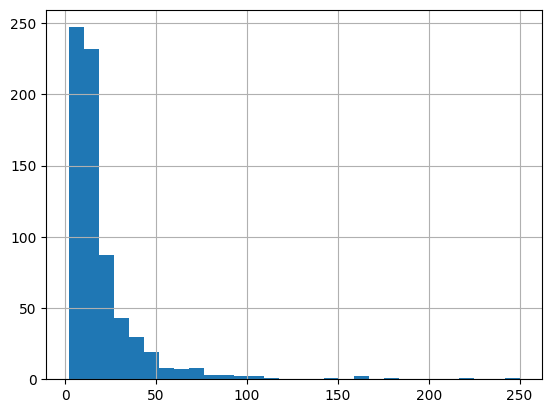

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

df = pd.read_csv("data.csv", delimiter = ';')
df.head()
df['isHate'] = df['isHate'].map(int)

# check class distribution
df['isHate'].value_counts(normalize = True)
train_text, temp_text, train_labels, temp_labels = train_test_split(df['comment'], df['isHate'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['isHate'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

max_seq_len = 25


In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask, return_dict):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict = return_dict)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[0.59760274 3.06140351]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask, return_dict = False)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# from babel.dates import format_date, format_datetime, format_time
# import time
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask, return_dict = False)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs + 10):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.759
Validation Loss: 0.652

 Epoch 2 / 10

Evaluating...

Training Loss: 0.657
Validation Loss: 0.631

 Epoch 3 / 10

Evaluating...

Training Loss: 0.660
Validation Loss: 0.697

 Epoch 4 / 10

Evaluating...

Training Loss: 0.641
Validation Loss: 0.689

 Epoch 5 / 10

Evaluating...

Training Loss: 0.681
Validation Loss: 0.623

 Epoch 6 / 10

Evaluating...

Training Loss: 0.681
Validation Loss: 0.626

 Epoch 7 / 10

Evaluating...

Training Loss: 0.647
Validation Loss: 0.635

 Epoch 8 / 10

Evaluating...

Training Loss: 0.617
Validation Loss: 0.737

 Epoch 9 / 10

Evaluating...

Training Loss: 0.651
Validation Loss: 0.665

 Epoch 10 / 10

Evaluating...

Training Loss: 0.618
Validation Loss: 0.646

 Epoch 11 / 10

Evaluating...

Training Loss: 0.664
Validation Loss: 0.745

 Epoch 12 / 10

Evaluating...

Training Loss: 0.628
Validation Loss: 0.607

 Epoch 13 / 10

Evaluating...

Training Loss: 0.611
Validation Loss: 0.604

 Epoch 14 / 10

Eval

**BERT MODEL III and XLNET**

In [ ]:
https://colab.research.google.com/drive/10jrcpd48fVS-z-0wx9sRJT-Fg2NChYz_#scrollTo=TCCuiUR2KQJVb

***GET ANTIVAX TWEETS***

In [ ]:
# Use the Twitter API to fetch tweets from tweetID's.
import pandas as pd
import tweepy
import time
import datetime
from google.colab import files

# Load the csv file into a Pandas dataframe
df = pd.read_csv('final.csv')

# Twitter API credentials
consumer_key = "R8qM8JOOdrzbAsXiNCvsUlYHy"
consumer_secret = "Twk3EZ2vB3cHPvIMtwuBMFLji0ShBPf7yJnpnX8rx0soZdwmXX"
access_token = "1545804938961248256-jvsnLkl0reyuwFn0SiM9ne1MfkSFZG"
access_token_secret = "wbnh5jvQacgZcz5o4s70mDVQD3R3kJQett7jvKNs8gV7A"

# Authenticate to Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create API object
api = tweepy.API(auth)

# Add a new column for the tweet body
df['tweet_body'] = None

# Create a backup file with a timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
backup_filename = f"VaxMisinfoData_{timestamp}.csv"
df.to_csv(backup_filename, index=False)

# Loop through each row in the dataframe, upload 2500 checkpoint table and proceed.
cnt = 0
for index, row in df.iloc[13000:].iterrows():
    if row['tweet_body'] is not None: continue
    time.sleep(3.1)
    cnt += 1
    # Save a checkpoint every 500 tweets
    if cnt % 500 == 0:
        checkpoint_filename = f"VaxMisinfoData_{timestamp}_checkpoint_{cnt}.csv"
        df.to_csv(checkpoint_filename, index=False)
        print(f"Checkpoint saved: {checkpoint_filename}")
    try:
        # Make API request to retrieve the tweet body
        tweet = api.get_status(row['id'])
        tweet_body = tweet.text
        # Store the tweet body in the dataframe
        df.at[index, 'tweet_body'] = tweet_body
        print("Success!")
        print(cnt)
    except tweepy.TweepError as e:
        # Handle any errors that occur during API requests
        print(f"Failed to retrieve tweet for id {row['id']}: {e}")

# Save the final version of the file
final_filename = f"VaxMisinfoData_{timestamp}_final.csv"
df.to_csv('{final_filename}', index=False)
print(f"Final version saved: {final_filename}")

***ANOTHER WAY TO FETCH REDDIT DATA ANTIVAX***

In [ ]:
!pip install praw
import csv
import praw

# Set up a Reddit instance
reddit = praw.Reddit(client_id='Z5WJjxdcQoeCHCt9aMCnkw',
                     client_secret='2ERuzmkKLnXpwZ1_QHbPptDVgqjHPw',
                     user_agent='prabh_gravity')

# Define the subreddits you want to fetch data from
subreddits = ['AntiVaxxers']

# Open a CSV file for writing
with open('posts.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Subreddit', 'Title'])

    # Fetch the latest 10 posts from each subreddit
    for subreddit in subreddits:
        subreddit = reddit.subreddit(subreddit)
        for submission in subreddit.new(limit=100):
            writer.writerow([subreddit.display_name, submission.title])


***GET INCEL DATA COMMENTS AND OTHER STUFF***

In [ ]:
import pandas as pd
import requests #Pushshift accesses Reddit via an url so this is needed
import json #JSON manipulation
import csv #To Convert final table into a csv file to save to your machine
import time
import datetime

In [ ]:
df = pd.read_csv("brain.csv")
df.head()
df.drop(columns=['Flair', 'Permalink', 'Url'], inplace=True)

# Add dummy columns to dataframe
# %%capture
for i in range(50):
    df['Comment' + str(i)] = [None] * len(df)
    df["Comment" + str(i) + " User"] = [None] * len(df)
    df["Comment" + str(i) + " Date"] = [None] * len(df)

In [ ]:
def getComments(row):
    uniqueUsers = set()
    # Get post ID
    postID = row['Post ID']
    url = 'https://api.pushshift.io/reddit/submission/comment_ids/' + postID
    r = requests.get(url)
    #Load JSON data from webpage into data variable
    data = json.loads(r.text)
    #return the data element which contains all the submissions data
    arrComments = data['data']
    commentsFinal = []
    for i in range(len(arrComments)):
        url_comments = 'https://api.pushshift.io/reddit/comment/search?ids=' + arrComments[i]
        comments = requests.get(url_comments)
        data = json.loads(comments.text)
        if len(data['data']) > 0:
            commentBody = data['data'][0]
            commentsFinal.append(commentBody['body'])
            if 'author' in commentBody:
                uniqueUsers.add(commentBody['author'])
                # Add the author to the dataframe
                row['Comment' + str(i) + " User"] = commentBody['author']
            # Now add the time stamp to the dataframe.
            if 'retrieved_on' in commentBody:
                row["Comment" + str(i) + " Date"] = datetime.datetime.fromtimestamp(commentBody['retrieved_on'])

    for i in range(min(len(commentsFinal), 50)):
        row['Comment' + str(i)] = commentsFinal[i]

    row['UniqueComments'] = len(uniqueUsers)

    return row

# Loop thru each post in the data frame and add new columns for columns.
df_test = df[:3].apply(getComments, axis = 1)
df_test.to_csv('file1.csv')

***LEXICON MODEL***



In [ ]:
import pandas as pd
import datetime as dt
from pmaw import PushshiftAPI
api = PushshiftAPI()
pip install pmaw

before = int(dt.datetime(2013,12,1,0,0).timestamp())
after = int(dt.datetime(2013,2,1,0,0).timestamp())

subreddit="Incelswithouthate"
limit=100
comments = api.search_comments(subreddit=subreddit, limit=limit, before=before, after=after)
print(f'Retrieved {len(comments)} comments from Pushshift')

comments_df = pd.DataFrame(comments)
# preview the comments data
comments_df.head(5)

In [ ]:
import spacy
### RUN ALL THESE COMMANDS LOCALLY ##
# Run pip install spacy
# Run conda install -c conda-forge spacy
# Run python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [ ]:
import string
def remove_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(s):
    return " ".join([word for word in s.split() if word not in spacy.lang.en.stop_words.STOP_WORDS])

def lemmatize(s):
    return " ".join([word.lemma_ for word in nlp(s)])

# print(type(comments_df["body"][0]))
for i, s in enumerate(comments_df["body"]):
    comments_df["body"][i] = remove_punctuation(s)
# comments_df["body"].map(remove_punctuation)
print(comments_df["body"].head(5))

In [ ]:
import tensorflow_datasets as tfds

train, test, validation = tfds.load('goemotions', split=['train','test','validation'], shuffle_files=True)

In [ ]:
seq_train_comments = get_sequences(tk, train_comments)
seq_val_comments = get_sequences(tk, val_comments)

In [ ]:
import praw


reddit = praw.Reddit(client_id="wMYO2Oa0xznPcZ_1ulsZPA",         # your client id
                               client_secret="uRUhfNSnvHN-BOb1p8l62y5ZFfoGLw",      # your client secret
                               user_agent="Research_Scraping")        # your user agent


subreddit = reddit.subreddit('badwomensanatomy')

conversedict = {}
hot_python = subreddit.hot(limit=10)

for submission in hot_python:
    if not submission.stickied:
        print('Title: {}, ups: {}, downs: {}, Have we visited?: {}, subid: {}, Authot: {}'.format(submission.title,
                                                                                                   submission.ups,
                                                                                                   submission.downs,
                                                                                                   submission.visited,
                                                                                                   submission.id,
                                                                                                  submission.author
                                                                                            ))

        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
          print(comment.body+"\n")









**PREFETCHING FOR LEXICON MODEL**

In [ ]:
#working code from here
import pandas as pd
import requests #Pushshift accesses Reddit via an url so this is needed
import json #JSON manipulation
import csv #To Convert final table into a csv file to save to your machine
import time
import datetime

#Adapted from this https://gist.github.com/dylankilkenny/3dbf6123527260165f8c5c3bc3ee331b
#This function builds an Pushshift URL, accesses the webpage and stores JSON data in a nested list
def getPushshiftData(query, after, before, sub):
    #Build URL
    url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=1000&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
    #Print URL to show user
    print(url)
    #Request URL
    r = requests.get(url)
    #Load JSON data from webpage into data variable
    data = json.loads(r.text)
    #return the data element which contains all the submissions data
    return data['data']

#This function will be used to extract the key data points from each JSON result
def collectSubData(subm):
    #subData was created at the start to hold all the data which is then added to our global subStats dictionary.
    subData = list() #list to store data points
    title = subm['title']
    url = subm['url']
    #flairs are not always present so we wrap in try/except
    try:
        flair = subm['link_flair_text']
    except KeyError:
        flair = "NaN"
    author = subm['author']
    sub_id = subm['id']
    body = subm['selftext']
    score = subm['score']
    created = datetime.datetime.fromtimestamp(subm['created_utc']) #1520561700.0
    numComms = subm['num_comments']
    permalink = subm['permalink']
    #Put all data points into a tuple and append to subData
    subData.append((sub_id,body,title,url,author,score,created,numComms,permalink,flair))
    #Create a dictionary entry of current submission data and store all data related to it
    subStats[sub_id] = subData

#Create your timestamps and queries for your search URL
#https://www.unixtimestamp.com/index.php > Use this to create your timestamps
after = "1451586600" #Submissions after this timestamp (1577836800 = 01 Jan 20)
before = "1640889000" #Submissions before this timestamp (1607040000 = 04 Dec 20)
query = "" #Keyword(s) to look for in submissions
sub = "Incels" #Which Subreddit to search in

#subCount tracks the no. of total submissions we collect
subCount = 0
#subStats is the dictionary where we will store our data.
subStats = {}

# We need to run this function outside the loop first to get the updated after variable
data = getPushshiftData(query, after, before, sub)
# Will run until all posts have been gathered i.e. When the length of data variable = 0
# from the 'after' date up until before date
while len(data) > 0: #The length of data is the number submissions (data[0], data[1] etc), once it hits zero (after and before vars are the same) end
    for submission in data:
        collectSubData(submission)
        subCount+=1
    # Calls getPushshiftData() with the created date of the last submission
    print(len(data))
    print(str(datetime.datetime.fromtimestamp(data[-1]['created_utc'])))
    #update after variable to last created date of submission
    after = data[-1]['created_utc']
    #data has changed due to the new after variable provided by above code
    data = getPushshiftData(query, after, before, sub)

print(len(data))

In [ ]:
print(str(len(subStats)) + " submissions have added to list")
print("1st entry is:")
print(list(subStats.values())[0][0][1] + " created: " + str(list(subStats.values())[0][0][5]))
print("Last entry is:")
print(list(subStats.values())[-1][0][1] + " created: " + str(list(subStats.values())[-1][0][5]))
def updateSubs_file():
    upload_count = 0
    #location = "\\Reddit Data\\" >> If you're running this outside of a notebook you'll need this to direct to a specific location
    print("input filename of submission file, please add .csv")
    filename = input() #This asks the user what to name the file
    file = filename
    with open(file, 'w', newline='', encoding='utf-8') as file:
        a = csv.writer(file, delimiter=',')
        headers = ["Post ID","Title","Body","Url","Author","Score","Publish Date","Total No. of Comments","Permalink","Flair"]
        a.writerow(headers)
        for sub in subStats:
            a.writerow(subStats[sub][0])
            upload_count+=1

        print(str(upload_count) + " submissions have been uploaded")
updateSubs_file()

In [ ]:
lexicon_list.sort()

In [ ]:
from itertools import zip_longest

ind = [i for i in range(1300)]
lext_dict = zip_longest(lexicon_list,ind)
lext_dict = dict(lext_dict)

In [ ]:
def Convert(lst):
    res_dct = {i: lst[i + 1] for i in range(0, len(lst), 2)}
    return res_dct

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def clean_data(text):
  text = ''.join([ele for ele in text if ele not in string.punctuation])
  text = text.lower()
  text = ' '.join([ele for ele in text.split() if ele not in stopwords])
  text = ''.join([ele for ele in text if not ele.isdigit()])
  return text

data = list(map(clean_data, s))

data

In [ ]:
for i in range(len(data)):

  n = len(data[i].split())
  l = len(lexicon_list)

  words = data[i].split()

  cnt = 0
  for k in range(n):

    if lext_dict.get(words[k]):
      cnt+=1

  print((cnt/n)*100)